In [1]:
import numpy as np
import scipy.stats
import matplotlib.pylab as plt
import os, sys
sys.path.insert(0, "../")
import geepee.aep_models as aep
import geepee.ep_models as ep
%matplotlib inline
np.random.seed(42)
import pdb

In [2]:
# We first define several utility functions

def kink_true(x):
    fx = np.zeros(x.shape)
    for t in range(x.shape[0]):
        xt = x[t]
        if xt < 4:
            fx[t] = xt + 1
        else:
            fx[t] = -4*xt + 21
    return fx


def kink(T, process_noise, obs_noise, xprev=None):
    if xprev is None:
        xprev = np.random.randn()
    y = np.zeros([T, ])
    x = np.zeros([T, ])
    xtrue = np.zeros([T, ])
    for t in range(T):
        if xprev < 4:
            fx = xprev + 1
        else:
            fx = -4*xprev + 21

        xtrue[t] = fx
        x[t] = fx + np.sqrt(process_noise)*np.random.randn()
        xprev = x[t]
        y[t] = x[t] + np.sqrt(obs_noise)*np.random.randn()

    return xtrue, x, y
    
def plot_latent(model, y, plot_title=''):
    # make prediction on some test inputs
    N_test = 200
    x_test = np.linspace(-4, 6, N_test)
    x_test = np.reshape(x_test, [N_test, 1])
    if isinstance(model, aep.SGPSSM_Linear):
        zu = model.dyn_layer.zu
    else:
        zu = model.sgp_layer.zu
    mu, vu = model.predict_f(zu)
    mf, vf = model.predict_f(x_test)
    # plot function
    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.plot(x_test[:,0], kink_true(x_test[:,0]), '-', color='k')
    ax.plot(zu, mu, 'ob')
    ax.plot(x_test[:,0], mf[:,0], '-', color='b')
    ax.fill_between(
        x_test[:,0], 
        mf[:,0] + 2*np.sqrt(vf[:,0]), 
        mf[:,0] - 2*np.sqrt(vf[:,0]), 
        alpha=0.2, edgecolor='b', facecolor='b')
    ax.plot(
        y[0:model.N-1], 
        y[1:model.N], 
        'r+', alpha=0.5)
    mx, vx = model.get_posterior_x()
    ax.set_xlabel(r'$x_{t-1}$')
    ax.set_ylabel(r'$x_{t}$')
    ax.set_xlim([-4, 6])
    ax.set_ylim([-7, 7])
    plt.title(plot_title)
    plt.savefig('/tmp/kink_'+plot_title+'.pdf')

In [3]:
# generate a dataset from the kink function above
T = 200
process_noise = 0.2
obs_noise = 0.1
(xtrue, x, y) = kink(T, process_noise, obs_noise)
y_train = np.reshape(y, [y.shape[0], 1])

# init hypers
Dlatent = 1
Dobs = 1
M = 15
C = 1*np.ones((1, 1))
R = np.ones(1)*np.log(obs_noise)/2
lls = np.reshape(np.log(2), [Dlatent, ])
lsf = np.reshape(np.log(2), [1, ])
zu = np.linspace(-1, 5, M)
zu = np.reshape(zu, [M, 1])
lsn = np.log(process_noise)/2
params = {'ls': lls, 'sf': lsf, 'sn': lsn, 'R': R, 'C': C, 'zu': zu}
# params = {'C': C}

alpha = 0.001
epoch 0/1000
epoch 50/1000
epoch 100/1000
epoch 150/1000
epoch 200/1000
epoch 250/1000
epoch 300/1000
epoch 350/1000
epoch 400/1000
epoch 450/1000
epoch 500/1000
epoch 550/1000
epoch 600/1000
epoch 650/1000
epoch 700/1000
epoch 750/1000
epoch 800/1000
epoch 850/1000
epoch 900/1000
epoch 950/1000
epoch 0/1000
epoch 50/1000
epoch 100/1000
epoch 150/1000
epoch 200/1000
epoch 250/1000
epoch 300/1000
epoch 350/1000
epoch 400/1000
epoch 450/1000
epoch 500/1000
epoch 550/1000
epoch 600/1000
epoch 650/1000
epoch 700/1000
epoch 750/1000
epoch 800/1000
epoch 850/1000
epoch 900/1000
epoch 950/1000
alpha = 0.050
epoch 0/1000
epoch 50/1000
epoch 100/1000
epoch 150/1000
epoch 200/1000
epoch 250/1000
epoch 300/1000
epoch 350/1000
epoch 400/1000
epoch 450/1000
epoch 500/1000
epoch 550/1000
epoch 600/1000
epoch 650/1000
epoch 700/1000
epoch 750/1000
epoch 800/1000
epoch 850/1000
epoch 900/1000
epoch 950/1000
epoch 0/1000
epoch 50/1000
epoch 100/1000
epoch 150/1000
epoch 200/1000
epoch 250

../geepee/ep_models.py:988: RuntimeWarning: invalid value encountered in log
  const_term = -0.5 * np.log(2*np.pi*v_sum)
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:52: RuntimeWarning: invalid value encountered in sqrt



epoch 0/200
epoch 50/200
epoch 100/200
epoch 150/200


/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:53: RuntimeWarning: invalid value encountered in sqrt


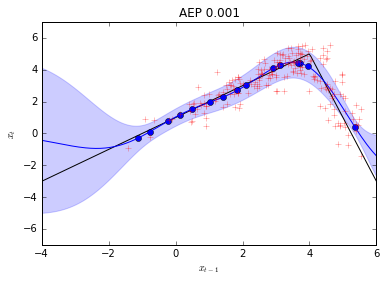

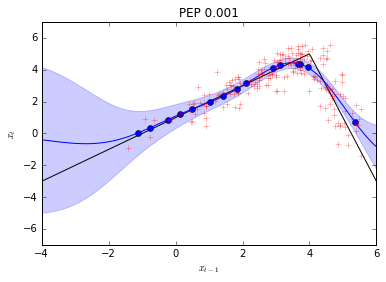

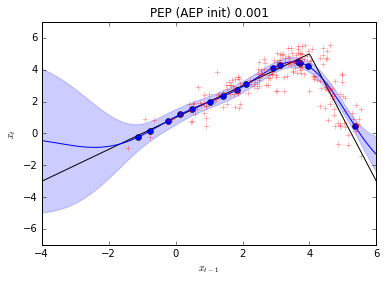

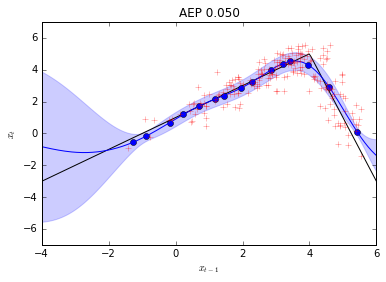

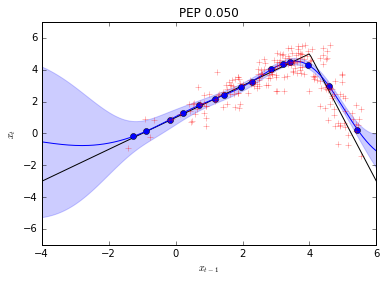

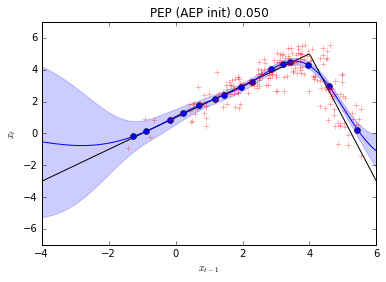

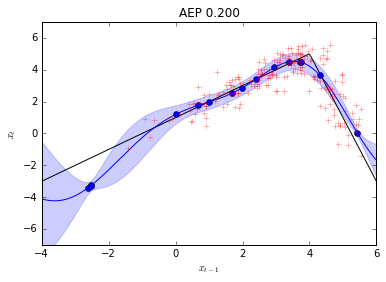

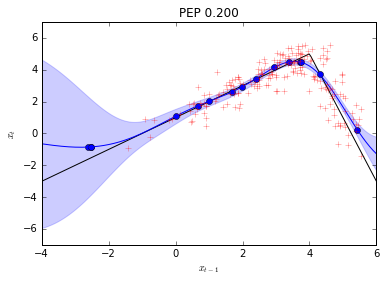

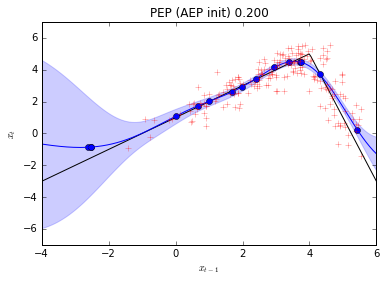

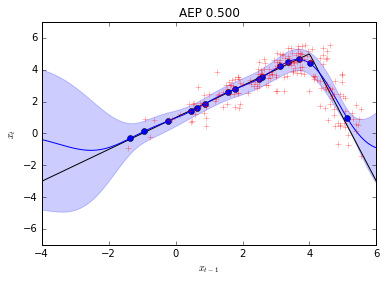

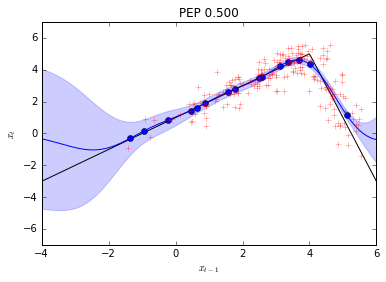

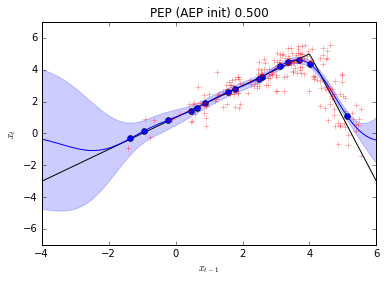

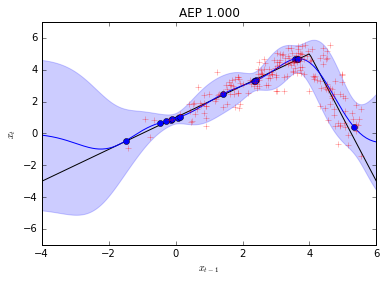

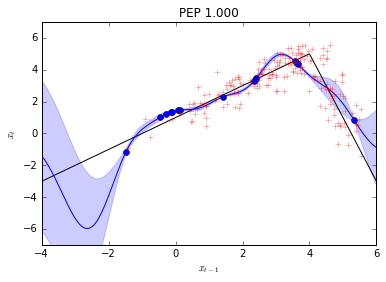

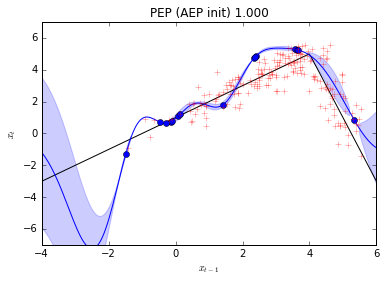

In [4]:
alphas = [0.001, 0.05, 0.2, 0.5, 1.0]
for alpha in alphas:
    print 'alpha = %.3f' % alpha
    # create AEP model
    model_aep = aep.SGPSSM_Linear(y_train, Dlatent, M, 
        lik='Gaussian', prior_mean=0, prior_var=1000)
    hypers = model_aep.init_hypers_old(y_train)
    for key in params.keys():
        hypers[key] = params[key]
    model_aep.update_hypers(hypers)
    # optimise
    model_aep.set_fixed_params(['C'])
    model_aep.optimise(method='L-BFGS-B', alpha=alpha, maxiter=10000, reinit_hypers=False)
    opt_hypers = model_aep.get_hypers()
    plot_latent(model_aep, y, 'AEP %.3f'%alpha)

    # create EP model
    model_ep = ep.SGPSSM(y_train, Dlatent, M, 
        lik='Gaussian', prior_mean=0, prior_var=1000)
    # init EP model using the AEP solution
    model_ep.update_hypers(opt_hypers)
    # run EP
    if alpha == 1.0:
        decay = 0.999
        parallel = True
        no_epochs = 200
    elif alpha == 0.001 or alpha == 0.05 or alpha ==0.2:
        decay = 0.5
        parallel = True
        no_epochs = 1000
    else:
        decay = 0.99
        parallel = True
        no_epochs = 500
    model_ep.inference(no_epochs=no_epochs, alpha=alpha, parallel=parallel, decay=decay)
    plot_latent(model_ep, y, 'PEP %.3f'%alpha)
    
    # create EP model
    model_ep = ep.SGPSSM(y_train, Dlatent, M, 
        lik='Gaussian', prior_mean=0, prior_var=1000)
    # init EP model using the AEP solution
    model_ep.update_hypers(opt_hypers)
    aep_sgp_layer = model_aep.dyn_layer
    Nm1 = aep_sgp_layer.N
    model_ep.sgp_layer.t1 = 1.0/Nm1 * np.tile(
        aep_sgp_layer.theta_2[np.newaxis, :, :], [Nm1, 1, 1])
    model_ep.sgp_layer.t2 = 1.0/Nm1 * np.tile(
        aep_sgp_layer.theta_1[np.newaxis, :, :, :], [Nm1, 1, 1, 1])
    model_ep.x_prev_1 = np.copy(model_aep.x_factor_1)
    model_ep.x_prev_2 = np.copy(model_aep.x_factor_2)
    model_ep.x_next_1 = np.copy(model_aep.x_factor_1)
    model_ep.x_next_2 = np.copy(model_aep.x_factor_2)
    model_ep.x_up_1 = np.copy(model_aep.x_factor_1)
    model_ep.x_up_2 = np.copy(model_aep.x_factor_2)
    model_ep.x_prev_1[0, :] = 0
    model_ep.x_prev_2[0, :] = 0
    model_ep.x_next_1[-1, :] = 0
    model_ep.x_next_2[-1, :] = 0
    # run EP
    if alpha == 1.0:
        decay = 0.999
        parallel = True
        no_epochs = 200
    elif alpha == 0.001 or alpha == 0.05 or alpha == 0.2:
        decay = 0.5
        parallel = True
        no_epochs = 1000
    else:
        decay = 0.99
        parallel = True
        no_epochs = 500
        
    model_ep.inference(no_epochs=no_epochs, alpha=alpha, parallel=parallel, decay=decay)
    
    plot_latent(model_ep, y, 'PEP (AEP init) %.3f'%alpha)